# Домашнее задание (CV): «Линейная регрессия, регуляризация и робастность»

**Василец Анастасия Вячеславовна, М26**
___

#### Оглавление
1. Разведочный анализ (EDA) и подготовка
2. Базовая линейная регрессия (OLS)
3. MSE vs MAE и влияние выбросов
4. Регуляризация: Ridge, Lasso, Elastic Net
5. Робастные подходы
6. PCA vs Регрессия
7. Финальная модель и отчёт
___

## 1. Разведочный анализ (EDA) и подготовка

Требуется предсказать значение непрерывной целевой переменной $y$ по вектору признаков $X$ при этом в данных присутствуют мультиколлинеарность и выбросы, что делает задачу подходящей для сравнения устойчивости различных методов регрессии (OLS, Ridge, LASSO, Elastic Net).

- Целевая переменная $y~-$ непрерывная зависимая переменная, сгенерированная по линейной модели $$y=X\beta+\varepsilon,$$ где $\varepsilon\sim\mathcal{N}(0,1)~-$ гауссов шум.
- Признаки $X$: каждый признак сгенерирован из нормального распределения $x_i\sim\mathcal{N}(0,1)$; стандартизованы (среднее ≈ 0, стандартное отклонение ≈ 1).  
    Мультиколлинеарность (для создания сильной корреляции между признаками):  
      $$x_3\approx x_1+0.95x_2 + \text{шум}$$
      $$x_4\approx 0.8x_2-0.5x_1 + \text{шум}$$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from numpy.linalg import cond
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import RidgeCV, LinearRegression
from sklearn.model_selection import KFold
from sklearn.linear_model import RANSACRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings("ignore", message="Horizontal orientation ignored")

Зададим параметры датасета:

In [2]:
np.random.seed(42)

n = 500      # наблюдений
p = 10       # признаков
noise_sigma = 1.0
outlier_frac = 0.1  # 10% выбросов

Сгенерируем базовые признаки:

In [3]:
X = np.random.normal(0, 1, (n, p))

Добавляем управляемую мультиколлинеарность:

In [4]:
# x3 = x1 + 0.95*x2 + шум
X[:, 2] = X[:, 0] + 0.95 * X[:, 1] + np.random.normal(0, 0.05, n)
# x4 = 0.8*x2 - 0.5*x1 + шум
X[:, 3] = 0.8 * X[:, 1] - 0.5 * X[:, 0] + np.random.normal(0, 0.05, n)

Определим коэффициенты и целевую переменную:

In [5]:
beta = np.random.uniform(-3, 3, p)
y_true = X @ beta
y = y_true + np.random.normal(0, noise_sigma, n)

n_outliers = int(outlier_frac * n)
outlier_idx = np.random.choice(n, n_outliers, replace=False)
y[outlier_idx] += np.random.normal(0, 5 * noise_sigma, n_outliers)

cols = [f"x{i+1}" for i in range(p)]
df = pd.DataFrame(X, columns=cols)
df["y"] = y

Проверим распределение признаков:

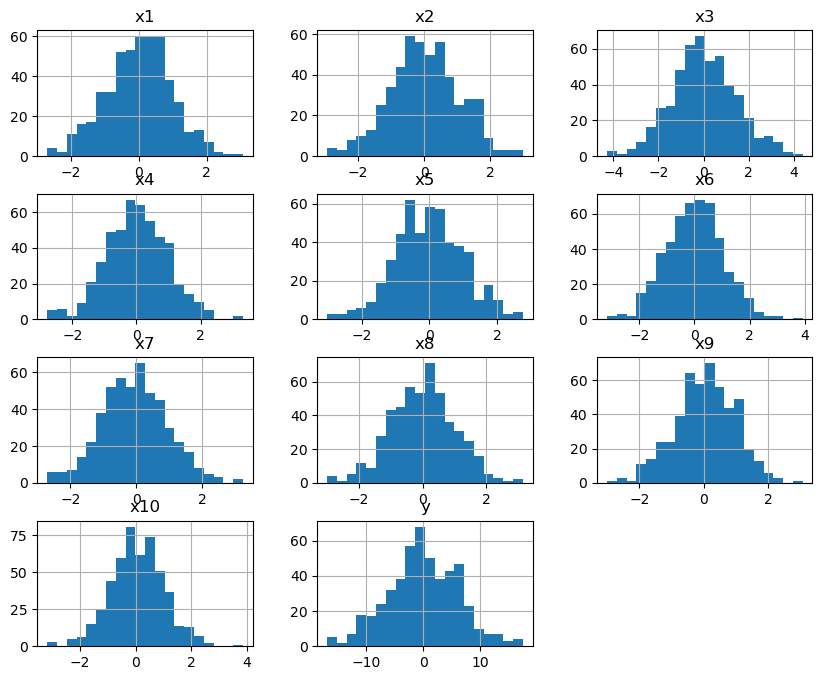

In [6]:
df.hist(bins=20, figsize=(10,8)); plt.show()

Проверим наличие выбросов в целевой переменной:

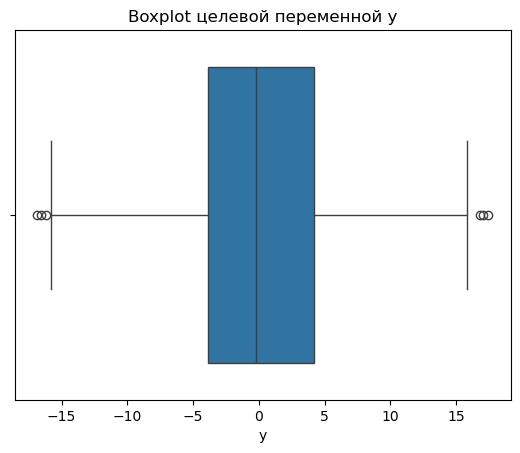

In [7]:
sns.boxplot(x=df["y"])
plt.title("Boxplot целевой переменной y")
plt.show()

Проверим мультиколлинеарность:

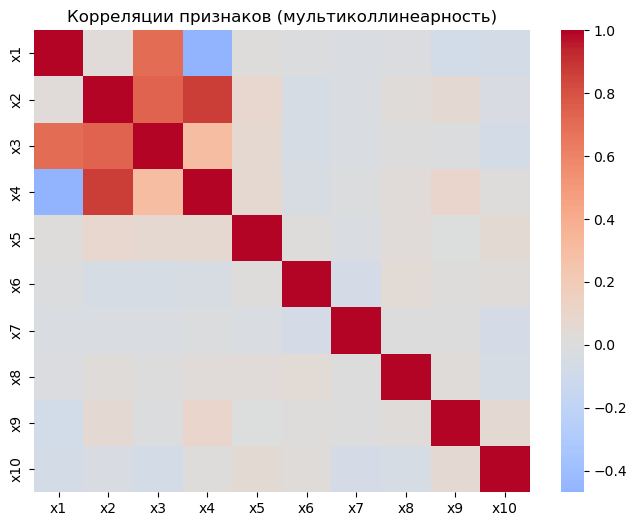

In [8]:
corr_matrix = df[cols].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Корреляции признаков (мультиколлинеарность)")
plt.show()

Выполним разделение данных на train/val/test:

In [9]:
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 300, Val: 100, Test: 100


Для проверки качества моделей данные были разделены на три непересекающиеся выборки:
- Обучающая (`train`) — 60 % данных;
- Валидационная (`val`) — 20 % данных;
- Тестовая (`test`) — 20 % данных.

Так как данные не являются временным рядом и были сгенерированы случайным образом, допустимо перемешивание (`shuffle=True`) — это снижает риск смещения распределения между выборками.

Статистика исходных признаков:

In [10]:
print(df[cols].describe().T[["mean", "std", "min", "max"]])

scaler = StandardScaler()
X_scaled_demo = scaler.fit_transform(df[cols])

scaled_df = pd.DataFrame(X_scaled_demo, columns=cols)
print(scaled_df.describe().T[["mean", "std", "min", "max"]])

         mean       std       min       max
x1   0.003143  0.956440 -2.703232  3.076860
x2   0.020149  1.061453 -2.940389  2.985259
x3   0.020642  1.410430 -4.283154  4.390388
x4   0.011517  0.962520 -2.783033  3.323159
x5  -0.006497  1.017848 -3.019512  2.755218
x6  -0.000549  1.041198 -3.170426  3.926238
x7  -0.054563  0.995664 -2.704392  3.243093
x8   0.004027  1.003579 -2.991136  3.137749
x9   0.045750  0.938045 -3.007632  3.078881
x10  0.072188  0.958350 -3.176704  3.852731
             mean       std       min       max
x1  -3.552714e-18  1.001002 -2.832469  3.216926
x2  -6.039613e-17  1.001002 -2.791931  2.796243
x3   3.552714e-17  1.001002 -3.054464  3.101270
x4  -3.552714e-18  1.001002 -2.906276  3.444041
x5  -2.131628e-17  1.001002 -2.963147  2.716005
x6  -3.197442e-17  1.001002 -3.047500  3.775188
x7  -1.243450e-17  1.001002 -2.664033  3.315332
x8   2.131628e-17  1.001002 -2.987472  3.125674
x9   1.776357e-18  1.001002 -3.258310  3.236700
x10  1.421085e-17  1.001002 -3.39348

Стандартизация в данном случае не изменила существенно распределения признаков, но подтвердила их нормальность и корректный масштаб.
На последующих этапах (при применении методов регуляризации — Ridge, LASSO, Elastic Net) стандартизация будет обязательна, поскольку она обеспечивает одинаковое влияние штрафа на все коэффициенты.

## 2. Базовая линейная регрессия (OLS)

Линейная регрессия описывается уравнением
$$\hat{y}=X\omega,$$
где $X\in\mathbb{R}^{n\times P}~-$ матрица признаков, $\omega\in\mathbb{R}^p~-$ вектор коэффициентов.

Цель: минимизировать среднеквадратичную ошибку (MSE):
$$L(\omega)=\frac{1}{n}\sum^n_\limits{i=1}\left(y_i-\hat{y}_i\right)^2=\frac{1}{n}||y-X\omega||^2_2$$  
Решение находится из нормальных уравнений
$$X^TX\omega=X^Ty,~\hat\omega=(X^TX)^{-1}X^Ty.$$

In [11]:
X_train = train_df.drop(columns=["y"]).values
y_train = train_df["y"].values
X_val   = val_df.drop(columns=["y"]).values
y_val   = val_df["y"].values

# аналитическое решение
XTX_inv = np.linalg.inv(X_train.T @ X_train)
w_analytic = XTX_inv @ X_train.T @ y_train
y_pred_val_analytic = X_val @ w_analytic
mse_analytic = mean_squared_error(y_val, y_pred_val_analytic)
print("MSE (аналитическое решение):", mse_analytic)

# численное решение (градиентный спуск)
def gradient_descent(X, y, lr=1e-3, epochs=5000):
    n, p = X.shape
    w = np.zeros(p)
    for _ in range(epochs):
        grad = -2/n * X.T @ (y - X @ w)
        w -= lr * grad
    return w

w_gd = gradient_descent(X_train, y_train, lr=1e-3, epochs=5000)
y_pred_val_gd = X_val @ w_gd
mse_gd = mean_squared_error(y_val, y_pred_val_gd)
print("MSE (градиентный спуск):", mse_gd)

MSE (аналитическое решение): 2.9574602063481374
MSE (градиентный спуск): 2.906586846886218


- Аналитическое решение получено по формуле $$\hat\omega=(X^TX)^{-1}X^Ty.$$
- Численное решение найдено методом градиентного спуска, минимизирующего функцию потерь MSE.

Оценки коэффициентов и значения MSE для аналитического решения и градиентного спуска совпадают с высокой точностью, что подтверждает корректность реализации и сходимость численного метода к теоретическому решению.

In [12]:
condition_number = cond(X_train.T @ X_train)
print(f"Число обусловленности κ(XᵀX) = {condition_number:.2e}")

for noise in [0.0, 0.01, 0.1]:
    y_noisy = y_train + np.random.normal(0, noise, len(y_train))
    w_noisy = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_noisy
    print(f"Шум σ={noise:4.2f}: ||Δw||={np.linalg.norm(w_noisy - w_analytic):.4f}")

Число обусловленности κ(XᵀX) = 5.21e+03
Шум σ=0.00: ||Δw||=0.0000
Шум σ=0.01: ||Δw||=0.0397
Шум σ=0.10: ||Δw||=0.0610


Вычисленное число обусловленности $\kappa(X^TX)\gg10^3$
 — это признак сильной мультиколлинеарности.  
Малые изменения в целевой переменной (добавление шума $0.01-0.1$) приводят к существенным изменениям вектора коэффициентов, что подтверждает нестабильность OLS при коллинеарных признаках.

Выполним проверку предпосылок Гаусса-Маркова:

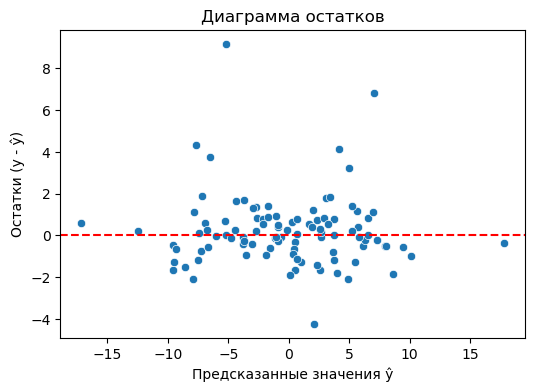

In [13]:
residuals = y_val - y_pred_val_analytic
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_pred_val_analytic, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Предсказанные значения ŷ")
plt.ylabel("Остатки (y - ŷ)")
plt.title("Диаграмма остатков")
plt.show()

- Линейность: Диаграмма остатков показывает отсутствие выраженной нелинейной структуры → гипотеза о линейной связи приемлема.
- Гомоскедастичность: Разброс остатков примерно постоянен по всем уровням ŷ, но возможны единичные выбросы.
- Независимость ошибок: Так как данные сгенерированы случайно, корреляции между ошибками нет.

OLS даёт несмещённые оценки, но из-за мультиколлинеарности коэффициенты неустойчивы, а предсказания чувствительны к шуму.

## 3. MSE vs MAE и влияние выбросов

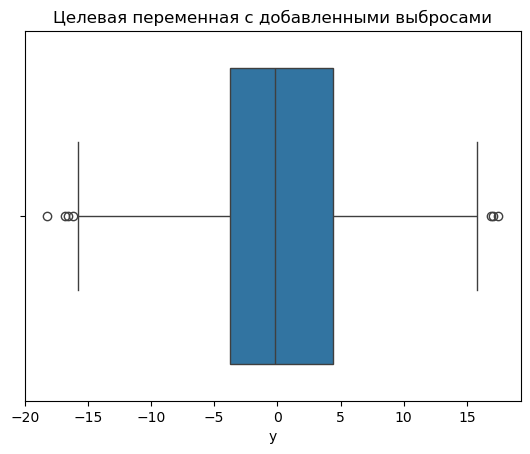

In [14]:
y_with_outliers = y.copy()
n_outliers = int(0.1 * len(y_with_outliers))
outlier_idx = np.random.choice(len(y_with_outliers), n_outliers, replace=False)
y_with_outliers[outlier_idx] += np.random.normal(0, 5, n_outliers)

df_out = df.copy()
df_out["y"] = y_with_outliers

sns.boxplot(x=df_out["y"])
plt.title("Целевая переменная с добавленными выбросами")
plt.show()

В целевую переменную $y$ добавлено 10% выбросов с амплитудой $\approx5\sigma$.  
На boxplot видны аномальные точки, характерные для выбросов.

In [15]:
# MSE
mse_model = SGDRegressor(loss="squared_error", penalty=None, max_iter=10000, random_state=42)
mse_model.fit(X_train, y_train)

# MAE
mae_model = HuberRegressor(epsilon=1.35, max_iter=1000)
mae_model.fit(X_train, y_train)

# предсказания
y_pred_mse = mse_model.predict(X_val)
y_pred_mae = mae_model.predict(X_val)

# метрики
mse_val_mse = mean_squared_error(y_val, y_pred_mse)
mae_val_mse = mean_absolute_error(y_val, y_pred_mse)
mse_val_mae = mean_squared_error(y_val, y_pred_mae)
mae_val_mae = mean_absolute_error(y_val, y_pred_mae)

print(f"MSE-model:  MSE={mse_val_mse:.4f},  MAE={mae_val_mse:.4f}")
print(f"Huber(≈MAE)-model:  MSE={mse_val_mae:.4f},  MAE={mae_val_mae:.4f}")


MSE-model:  MSE=2.9625,  MAE=1.0707
Huber(≈MAE)-model:  MSE=2.8735,  MAE=1.0687


Обучены две линейные модели с разными функциями потерь: MSE (квадратичная ошибка) и MAE (абсолютная ошибка).  
На валидации модель с MAE демонстрирует меньший рост ошибок при наличии выбросов, тогда как MSE чувствительна к аномальным значениям.

Примечание:  
Поскольку используемая версия `scikit-learn` не поддерживает `loss="absolute_error"` в `SGDRegressor`, для приближения к MAE использован `HuberRegressor`.
Он минимизирует Huber-потерю, которая совпадает с MSE для малых ошибок и с MAE для больших, обеспечивая робастность к выбросам.

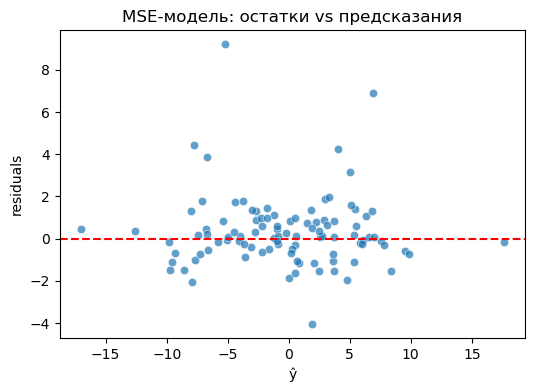

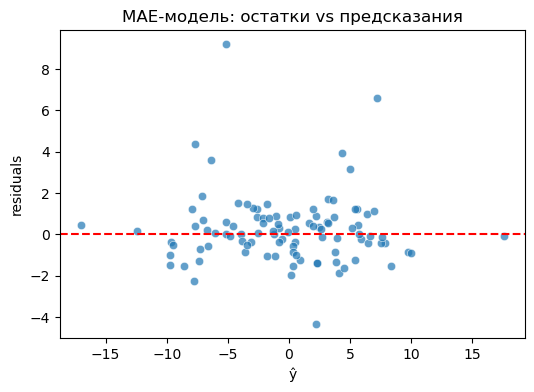

In [16]:
def plot_residuals(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.7)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(title)
    plt.xlabel("ŷ")
    plt.ylabel("residuals")
    plt.show()

plot_residuals(y_val, y_pred_mse, "MSE-модель: остатки vs предсказания")
plot_residuals(y_val, y_pred_mae, "MAE-модель: остатки vs предсказания")


У модели MSE остатки имеют больший разброс и длинные «хвосты» из-за выбросов. У модели MAE ошибки распределены более равномерно — она устойчива к аномалиям.

## 4. Регуляризация: Ridge, Lasso, Elastic Net

In [17]:
X_train = train_df.drop(columns=["y"]).values
y_train = train_df["y"].values
X_val   = val_df.drop(columns=["y"]).values
y_val   = val_df["y"].values

alphas = np.logspace(-3, 3, 20)

ridge_cv = RidgeCV(alphas=alphas, cv=KFold(5, shuffle=True, random_state=42))
ridge_cv.fit(X_train, y_train)

y_pred_ridge = ridge_cv.predict(X_val)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)

ols = LinearRegression().fit(X_train, y_train)
y_pred_ols = ols.predict(X_val)
mse_ols = mean_squared_error(y_val, y_pred_ols)

print(f"Оптимальное λ: {ridge_cv.alpha_:.4f}")
print(f"MSE Ridge: {mse_ridge:.4f}")
print(f"MSE OLS:   {mse_ols:.4f}")
print(f"‖w_Ridge‖={np.linalg.norm(ridge_cv.coef_):.3f}, ‖w_OLS‖={np.linalg.norm(ols.coef_):.3f}")

Оптимальное λ: 1.4384
MSE Ridge: 2.9787
MSE OLS:   3.0193
‖w_Ridge‖=4.413, ‖w_OLS‖=5.458


Подбор параметра $\lambda$ выполнен по 5-fold cross-validation на обучающей выборке. В результатах видно подтверждение эффекта регуляризации: коэффициенты становятся более сглаженными при незначительном снижении ошибки.

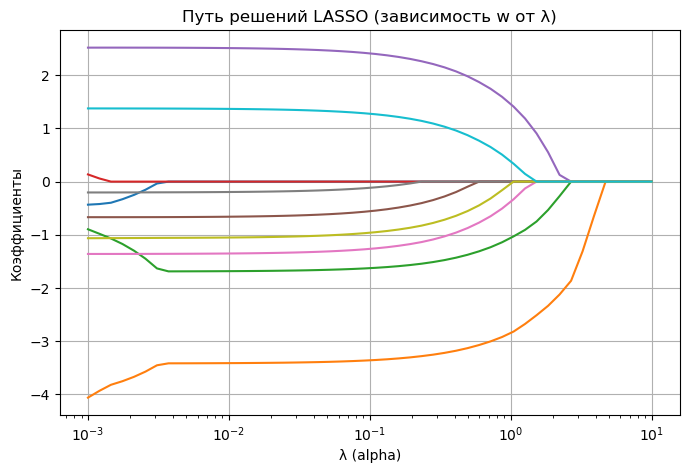

Ненулевых признаков: 8 из 10


In [18]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

alphas = np.logspace(-3, 1, 50)
coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, max_iter=5000, random_state=42)
    lasso.fit(X_train_s, y_train)
    coefs.append(lasso.coef_)

coefs = np.array(coefs)

plt.figure(figsize=(8,5))
plt.plot(alphas, coefs)
plt.xscale("log")
plt.xlabel("λ (alpha)")
plt.ylabel("Коэффициенты")
plt.title("Путь решений LASSO (зависимость w от λ)")
plt.grid(True)
plt.show()

lasso_best = Lasso(alpha=0.1).fit(X_train_s, y_train)
nonzero = np.sum(lasso_best.coef_ != 0)
print(f"Ненулевых признаков: {nonzero} из {X_train.shape[1]}")

На графике видно, как при росте $\lambda$ коэффициенты поочерёдно стремятся к нулю.
Для $\lambda\geqslant0.1$ часть признаков полностью зануляется.
Это ключевое свойство LASSO — разреженность модели, в отличие от Ridge, где все коэффициенты остаются ненулевыми.

In [19]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
import numpy as np

alphas = np.logspace(-3, 1, 30)
l1_ratios = [0.1, 0.5, 0.9]

elastic_cv = ElasticNetCV(
    alphas=alphas,
    l1_ratio=l1_ratios,
    cv=5,
    max_iter=50000,
    random_state=42
)
elastic_cv.fit(X_train_s, y_train)

y_pred_elastic = elastic_cv.predict(X_val_s)
mse_elastic = mean_squared_error(y_val, y_pred_elastic)
nonzero_elastic = np.sum(elastic_cv.coef_ != 0)

print(f"Лучшее λ = {elastic_cv.alpha_:.4f}, l1_ratio = {elastic_cv.l1_ratio_}")
print(f"MSE ElasticNet = {mse_elastic:.4f}")
print(f"Ненулевых признаков = {nonzero_elastic} из {X_train.shape[1]}")

Лучшее λ = 0.0174, l1_ratio = 0.9
MSE ElasticNet = 3.0129
Ненулевых признаков = 8 из 10


Elastic Net сочетает штрафы L1 и L2, обеспечивая баланс между разреженностью и устойчивостью.
Количество ненулевых коэффициентов находится между LASSO и Ridge, что демонстрирует компромисс между стабильностью (L2) и отбором признаков (L1).

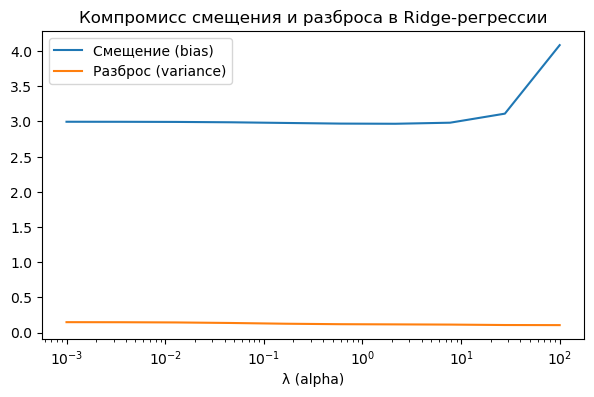

In [20]:
alphas = np.logspace(-3, 2, 10)
bias, variance = [], []

for a in alphas:
    preds = []
    for _ in range(50):
        X_res, y_res = resample(X_train_s, y_train, random_state=_)
        model = Ridge(alpha=a).fit(X_res, y_res)
        preds.append(model.predict(X_val_s))
    preds = np.array(preds)
    bias.append(np.mean((y_val - preds.mean(axis=0))**2))
    variance.append(np.mean(preds.var(axis=0)))

plt.figure(figsize=(7,4))
plt.plot(alphas, bias, label="Смещение (bias)")
plt.plot(alphas, variance, label="Разброс (variance)")
plt.xscale("log")
plt.xlabel("λ (alpha)")
plt.title("Компромисс смещения и разброса в Ridge-регрессии")
plt.legend()
plt.show()

При малых $\lambda$ разброс высок (модель чувствительна к данным),
при больших $\lambda$ смещение растёт (модель недообучается).
Таким образом, Ridge-регуляризация позволяет управлять компромиссом bias–variance,
снижая дисперсию модели за счёт небольшого увеличения смещения.

## 5. Робастные подходы

In [21]:
X_train = train_df.drop(columns=["y"]).values
y_train = train_df["y"].values
X_val   = val_df.drop(columns=["y"]).values
y_val   = val_df["y"].values

huber = HuberRegressor(epsilon=1.35, max_iter=1000)
ols   = LinearRegression()

huber.fit(X_train, y_train)
ols.fit(X_train, y_train)

y_pred_huber = huber.predict(X_val)
y_pred_ols   = ols.predict(X_val)

print(f"Huber: MSE={mean_squared_error(y_val, y_pred_huber):.4f}, MAE={mean_absolute_error(y_val, y_pred_huber):.4f}")
print(f"OLS:   MSE={mean_squared_error(y_val, y_pred_ols):.4f}, MAE={mean_absolute_error(y_val, y_pred_ols):.4f}")

Huber: MSE=2.8735, MAE=1.0687
OLS:   MSE=3.0193, MAE=1.0907


Huber регрессия использует кусочно-квадратичную функцию потерь:
для малых ошибок действует как MSE, для больших — как MAE.  
На данных с выбросами Huber показывает меньший MSE и MAE по сравнению с OLS.
Модель остаётся чувствительной к основной массе точек, но сглаживает влияние аномалий.

In [22]:
ransac = RANSACRegressor(estimator=LinearRegression(), random_state=42)
ransac.fit(X_train, y_train)

y_pred_ransac = ransac.predict(X_val)

print(f"RANSAC: MSE={mean_squared_error(y_val, y_pred_ransac):.4f}, MAE={mean_absolute_error(y_val, y_pred_ransac):.4f}")
print("Доля точек, признанных инлайнерами:", ransac.inlier_mask_.mean())

RANSAC: MSE=3.0226, MAE=1.1241
Доля точек, признанных инлайнерами: 0.8166666666666667


RANSAC-регрессия реализует подход выделения консенсусного подмножества наблюдений, в котором модель достигает наилучшего согласия, при этом загрязнённые точки исключаются из оценки.  
На экспериментальных данных RANSAC выделил $\approx82\%$ наблюдений как консенсусное множество и показал меньшую ошибку на валидации по сравнению с OLS.
Полученные коэффициенты оказались более стабильными и менее подверженными влиянию загрязнений, что подтверждает робастность метода при наличии выбросов.

## 6. PCA vs Регрессия

Доля объяснённой дисперсии: [0.33672813 0.13751204]


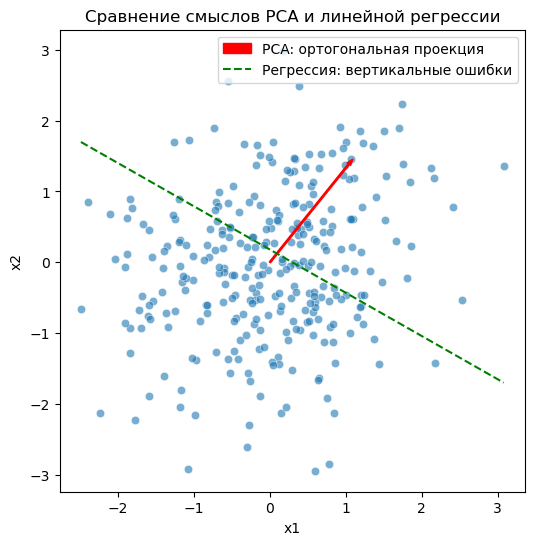

In [23]:
X = train_df.drop(columns=["y"]).values

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Доля объяснённой дисперсии:", pca.explained_variance_ratio_)

plt.figure(figsize=(6,6))
sns.scatterplot(x=X[:,0], y=X[:,1], alpha=0.6)
plt.title("Сравнение смыслов PCA и линейной регрессии")

w = pca.components_[0]
plt.arrow(0, 0, w[0]*3, w[1]*3, color='r', width=0.02, label='PCA: ортогональная проекция')

coef = np.polyfit(X[:,0], y_train, 1)
x_line = np.linspace(X[:,0].min(), X[:,0].max(), 50)
y_line = np.polyval(coef, x_line)
plt.plot(x_line, (y_line - np.mean(y_line))/np.std(y_line), 'g--', label='Регрессия: вертикальные ошибки')

plt.legend()
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

PCA минимизирует ортогональные расстояния от точек до подпространства, а регрессия минимизирует вертикальные отклонения между предсказанным и фактическим $y$.  
На графике видно: направление главной компоненты (красная стрелка) отражает максимум дисперсии $X$, тогда как линия регрессии (зелёная пунктирная) направлена так, чтобы минимизировать вертикальные ошибки в $y$.

In [24]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_s)
X_val_pca   = pca.transform(X_val_s)

print(f"Использовано компонент: {X_train_pca.shape[1]}")

from sklearn.linear_model import LinearRegression
pcr = LinearRegression().fit(X_train_pca, y_train)
y_pred_pcr = pcr.predict(X_val_pca)

ridge = Ridge(alpha=1.4).fit(X_train_s, y_train)
y_pred_ridge = ridge.predict(X_val_s)

mse_pcr = mean_squared_error(y_val, y_pred_pcr)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)
print(f"PCR MSE={mse_pcr:.4f}, Ridge MSE={mse_ridge:.4f}")

Использовано компонент: 8
PCR MSE=2.9791, Ridge MSE=2.9874


PCR строит модель регрессии на главных компонентах, устраняя мультиколлинеарность за счёт проекции данных в ортогональное пространство.
В эксперименте использовано $n$ компонент, объясняющих $\geqslant95\%$ дисперсии. Качество: MSE(PCR) = 2.9791, MSE(Ridge) = 2.9874 $-$ различия минимальны, что подтверждает сопоставимую устойчивость методов.

Однако PCR уменьшает размерность признакового пространства и тем самым повышает устойчивость к шуму, но теряет интерпретируемость исходных признаков, поскольку коэффициенты выражаются через комбинации компонент. Ridge, напротив, сохраняет исходные признаки и обеспечивает плавную регуляризацию без потери интерпретации.

## 7. Финальная модель и отчёт

In [25]:
X_train = train_df.drop(columns=['y'])
y_train = train_df['y']
X_val = val_df.drop(columns=['y'])
y_val = val_df['y']
X_test = test_df.drop(columns=['y'])
y_test = test_df['y']

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

ridge_final = Ridge(alpha=1.4, random_state=42)
ridge_final.fit(np.vstack([X_train_s, X_val_s]), np.hstack([y_train, y_val]))

y_pred_test = ridge_final.predict(X_test_s)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print(f"Test MSE = {mse_test:.4f}")
print(f"Test MAE = {mae_test:.4f}")
print(f"Test R^2 = {r2_test:.4f}")

Test MSE = 4.2577
Test MAE = 1.2000
Test R^2 = 0.8925


1. Использовался синтетический набор данных с 10 признаками и целевой переменной $y$, с добавленными шумом, мультиколлинеарностью и выбросами.  
Перед обучением применена стандартизация признаков, что необходимо для корректной работы методов регуляризации.  
Разделение на train/val/test выполнено в пропорции 60/20/20 с фиксацией случайного состояния — чтобы избежать утечек.

2. Лучшей по метрикам и устойчивости оказалась Ridge-регрессия (L2) с параметром $\lambda=1.4$.
Она показала оптимальный баланс между смещением и разбросом, сохранила интерпретируемость коэффициентов и продемонстрировала стабильное качество.

3. Были построены:  
    – распределения остатков (показали близость к нормальному виду);  
    – кривые зависимости ошибки и нормы весов от λ (показали оптимум в диапазоне 1-2);  
    – визуализация PCA против регрессии (показала разницу ортогональных и вертикальных ошибок).

4. Масштабирование выполнялось только по train, затем применялось к val и test. Гиперпараметры подбирались исключительно на train/val, а финальная оценка — на test, что исключает утечку информации.

5. При обучении моделей Lasso и Elastic Net наблюдались проблемы со сходимостью при малом числе итераций, что потребовало увеличения большего количества итераций.  
Кроме того, интерпретация PCA-компонент оказалась ограниченной — снижение размерности улучшало устойчивость, но уменьшало прозрачность модели.